In [1]:
from utils import CNNBackbone, ASTBackbone, get_device, SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, \
    Classifier, train, set_seed, plot_train_val_losses, test_model, get_classification_report, \
    free_gpu_memory
import torch
import torch.optim as optim
import numpy as np
import os

# DATA_PATH = "/home/alex/Downloads/archive(1)/data/"
DATA_PATH = os.path.join(os.getcwd(), "data/")
model_weights_path = os.path.join(os.getcwd(), "model_weights/")
assets_path = os.path.join(os.getcwd(), "assets/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
os.makedirs(model_weights_path, exist_ok=True)
os.makedirs(assets_path, exist_ok=True)

EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 8
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 256

if torch.cuda.is_available():
    print(f"Detected GPU: {torch.cuda.get_device_name(0)}")
    print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
else:
    print("CUDA is not available. No compatible GPU detected.")
DEVICE = get_device()

Detected GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Free GPU Memory: 100.00%


In [2]:
mel_specs_test_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=False)
mel_specs_train_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=True)

mel_specs_test_dl, _ = torch_train_val_split(dataset=mel_specs_test_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=.0, shuffle=False)
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(dataset=mel_specs_train_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=.2, shuffle=True)

### Overfit CNN model on one batch to make sure everything works

Training in overfitting mode...
Epoch 1, Loss at training set: 2.435631275177002
Epoch 20, Loss at training set: 5.439553933683783e-05
Epoch 40, Loss at training set: 7.57834204705432e-05
Epoch 60, Loss at training set: 3.799763135248213e-06
Epoch 80, Loss at training set: 1.7285287867707666e-06
Epoch 100, Loss at training set: 1.3261999356473098e-06


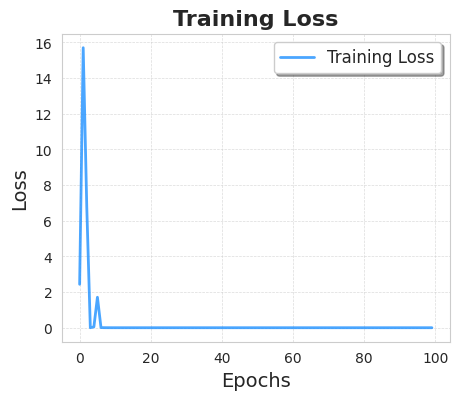

In [3]:
# prepare batch data and input shape
x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

# init CNN backbone and classifier
backbone = CNNBackbone(input_dims=input_shape, in_channels=cnn_in_channels, filters=cnn_filters, feature_size=cnn_out_feature_size)
model = Classifier(num_classes=NUM_CATEGORIES, backbone=backbone).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

# overfit model on a single batch
train_losses, _ = train(model=model, train_loader=mel_specs_train_dl, val_loader=mel_specs_val_dl,
        optimizer=optimizer, epochs=EPOCHS, device=DEVICE, overfit_batch=True)

plot_train_val_losses(train_losses=train_losses, val_losses=[], 
                      save_title=assets_path+"cnn_genre_train_val_losses.png")

### Train CNN + Classifier on Spectrograms

Free GPU Memory: 90.28%
Training started for model /home/vag/Documents/DSML/PatternRecognition/BeatPatrol/model_weights/cnn_genre_mel...
Epoch 1/100
	Average Training Loss: 10.015889771056898 (17.44s)
	Average Validation Loss: 4.689029459295602(1.20s)
Epoch 2/100
	Average Training Loss: 4.579921068309189 (17.79s)
	Average Validation Loss: 4.6993592730883895(1.33s)
Epoch 3/100
	Average Training Loss: 3.662485839484574 (17.20s)
	Average Validation Loss: 4.0066069539250995(1.18s)
Epoch 4/100
	Average Training Loss: 3.07427168950374 (16.73s)
	Average Validation Loss: 3.069829967515222(1.18s)
Epoch 5/100
	Average Training Loss: 2.199685014945604 (18.65s)
	Average Validation Loss: 3.332327867376393(1.77s)
Epoch 6/100
	Average Training Loss: 2.270901507113403 (18.72s)
	Average Validation Loss: 3.0931519444646507(1.25s)
Epoch 7/100
	Average Training Loss: 1.9358924384757037 (17.55s)
	Average Validation Loss: 2.8728080271133063(1.18s)
Epoch 8/100
	Average Training Loss: 1.4662943618831696 (16.5

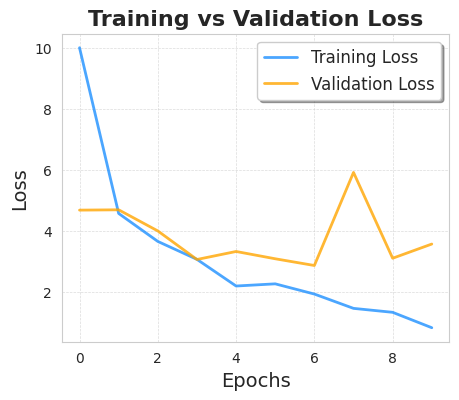

In [4]:
print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
# prepare batch data and input shape
x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

# init CNN backbone and classifier
set_seed(RANDOM_SEED)
backbone = CNNBackbone(input_dims=input_shape, in_channels=cnn_in_channels, filters=cnn_filters, feature_size=cnn_out_feature_size)
set_seed(RANDOM_SEED)  
model = Classifier(num_classes=NUM_CATEGORIES, backbone=backbone).to(device=DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

# train model
train_losses, val_losses = train(
    model=model, train_loader=mel_specs_train_dl, val_loader=mel_specs_val_dl,
    optimizer=optimizer, epochs=EPOCHS, save_path=model_weights_path+"cnn_genre_mel.pth",
    device=DEVICE, overfit_batch=False, patience=3
)

# plot losses
plot_train_val_losses(train_losses=train_losses, val_losses=val_losses, 
                      save_title=assets_path+"cnn_genre_train_val_losses.png")

# test  model
mel_y_true, mel_y_pred = test_model(model=model, dataloader=mel_specs_test_dl, device=DEVICE)

In [5]:
get_classification_report(np.hstack(mel_y_pred), np.hstack(mel_y_true))

              precision    recall  f1-score   support

           0       0.08      0.03      0.04        40
           1       0.45      0.80      0.58        40
           2       0.69      0.28      0.39        80
           3       0.44      0.35      0.39        80
           4       0.40      0.53      0.45        40
           5       0.33      0.05      0.09        40
           6       0.20      0.01      0.02        78
           7        nan      0.00       nan        40
           8       0.27      0.84      0.41       103
           9       0.25      0.06      0.10        34

    accuracy                           0.34       575
   macro avg       0.35      0.29      0.27       575
weighted avg       0.36      0.34      0.29       575

Micro-average precision: 0.34
Micro-average recall: 0.34
Micro-average F1-score: 0.34


### Overfit AST + Classifier on one batch to make sure everything works


Training in overfitting mode...
Epoch 1, Loss at training set: 2.5021133422851562
Epoch 20, Loss at training set: 1.0144097805023193
Epoch 40, Loss at training set: 0.2610860764980316
Epoch 60, Loss at training set: 0.15220262110233307
Epoch 80, Loss at training set: 0.1203317791223526
Epoch 100, Loss at training set: 0.10273082554340363


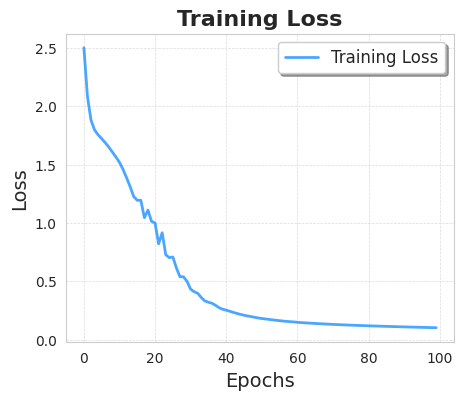

In [3]:
# prepare batch data and input shape
x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

# init AST backbone and classifier
backbone = ASTBackbone(
    fstride=10,                     # Frequency stride
    tstride=10,                     # Time stride
    input_fdim=input_shape[1],      # Number of frequency bins 
    input_tdim=input_shape[0],      # Number of time frames 
    imagenet_pretrain=True,         # Use ImageNet pretraining
    model_size='tiny224',           # Model size 
    feature_size=NUM_CATEGORIES     # Output feature size 
)
set_seed(RANDOM_SEED)  
model = Classifier(num_classes=NUM_CATEGORIES, backbone=backbone).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

# overfit model on a couple of batches
train_losses, _ = train(model=model, train_loader=mel_specs_train_dl, val_loader=mel_specs_val_dl,
        optimizer=optimizer, epochs=100, device=DEVICE, overfit_batch=True)


# plot losses
plot_train_val_losses(train_losses=train_losses, val_losses=[], 
                      save_title=assets_path+"cnn_genre_train_val_losses.png")

### Train AST + Classifier on Spectrograms

Free GPU Memory: 100.00%
Training started for model /home/vag/Documents/DSML/PatternRecognition/BeatPatrol/model_weights/ast_genre_mel...
Epoch 1/100
	Average Training Loss: 2.108781256717005 (100.52s)
	Average Validation Loss: 1.881005044641166(9.23s)
Epoch 2/100
	Average Training Loss: 1.8280847418359865 (99.01s)
	Average Validation Loss: 1.7927620534239144(9.34s)
Epoch 3/100
	Average Training Loss: 1.6714357000924809 (99.01s)
	Average Validation Loss: 1.677539377376951(9.24s)
Epoch 4/100
	Average Training Loss: 1.5263684231997567 (99.27s)
	Average Validation Loss: 1.6547705161160435(9.49s)
Epoch 5/100
	Average Training Loss: 1.3156812913490064 (99.88s)
	Average Validation Loss: 1.6066509999077896(9.22s)
Epoch 6/100
	Average Training Loss: 1.0637906170510627 (99.04s)
	Average Validation Loss: 1.682703079848454(9.25s)
Epoch 7/100
	Average Training Loss: 0.7910952210039287 (99.08s)
	Average Validation Loss: 1.8815397609924447(9.22s)
Epoch 8/100
	Average Training Loss: 0.541893490916722

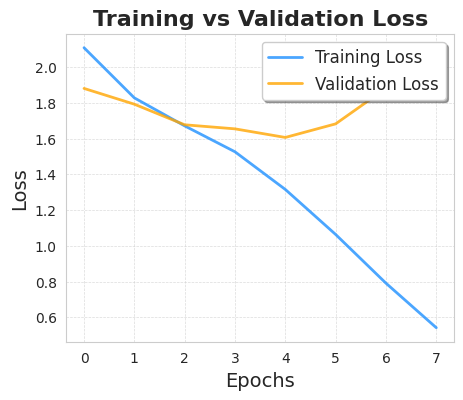

In [3]:
print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
# prepare batch data and input shape
x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

set_seed(RANDOM_SEED)

# init AST backbone and classifier
backbone = ASTBackbone(
    fstride=10,                     # Frequency stride
    tstride=10,                     # Time stride
    input_fdim=input_shape[1],      # Number of frequency bins 
    input_tdim=input_shape[0],      # Number of time frames 
    imagenet_pretrain=True,         # Use ImageNet pretraining
    model_size='tiny224',           # Model size 
    feature_size=NUM_CATEGORIES     # Output feature size 
)
set_seed(RANDOM_SEED)  
model = Classifier(num_classes=NUM_CATEGORIES, backbone=backbone).to(device=DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

# train model
train_losses, val_losses = train(
    model=model, train_loader=mel_specs_train_dl, val_loader=mel_specs_val_dl, optimizer=optimizer, 
    epochs=EPOCHS, save_path=model_weights_path+"ast_genre_mel.pth", device=DEVICE, 
    overfit_batch=False, regression_flag=False, patience=3
)

# plot losses
plot_train_val_losses(train_losses=train_losses, val_losses=val_losses, 
                      save_title=assets_path+"ast_genre_train_val_losses.png")

# test  model
mel_y_true, mel_y_pred = test_model(model=model, dataloader=mel_specs_test_dl, device=DEVICE)

In [5]:
get_classification_report(np.hstack(mel_y_pred), np.hstack(mel_y_true))

              precision    recall  f1-score   support

           0       0.25      0.33      0.29        40
           1       0.59      0.55      0.57        40
           2       0.43      0.46      0.45        80
           3       0.41      0.40      0.40        80
           4       0.65      0.38      0.48        40
           5       0.33      0.07      0.12        40
           6       0.52      0.65      0.58        78
           7       0.14      0.28      0.19        40
           8       0.33      0.25      0.29       103
           9       0.26      0.29      0.28        34

    accuracy                           0.38       575
   macro avg       0.39      0.37      0.36       575
weighted avg       0.40      0.38      0.38       575

Micro-average precision: 0.38
Micro-average recall: 0.38
Micro-average F1-score: 0.38
